In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from scipy.signal import find_peaks

In [8]:
# Opção 1: Usar caminho relativo (recomendado)
image_path = Path("../data/imagens/soja-37.jpg")


In [9]:
def msrcr(img, scales=[15, 80, 250]):
    img = np.float64(img) + 1.0
    msr = np.zeros_like(img)
    for scale in scales:
        gaussian = cv2.GaussianBlur(img, (0, 0), scale)
        msr += (np.log10(img) - np.log10(gaussian))
    msr = msr / len(scales)

    color_restoration = 125 * (np.log10(125 * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    msrcr = msr * color_restoration

    return msrcr


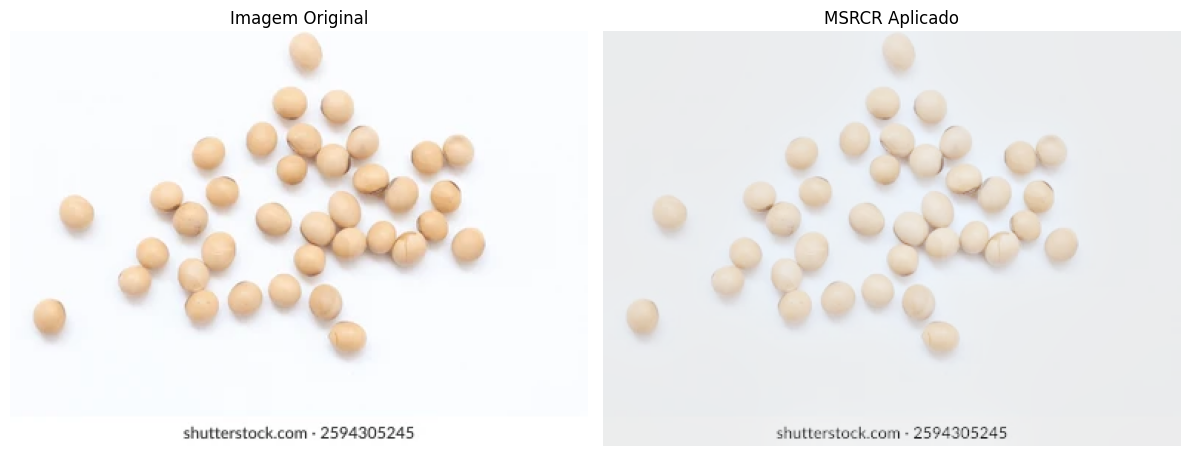

In [10]:
image = cv2.imread(str(image_path))
msrc = msrcr(image)

# Normalizar para o range [0, 255] para visualização
msrc_normalized = np.uint8(np.clip((msrc - msrc.min()) / (msrc.max() - msrc.min()) * 255, 0, 255))

# Converter de BGR para RGB (OpenCV usa BGR, matplotlib usa RGB)
msrc_rgb = cv2.cvtColor(msrc_normalized, cv2.COLOR_BGR2RGB)

# Plotar
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(msrc_rgb)
plt.title('MSRCR Aplicado')
plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
def verified_otsu(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_smooth = cv2.GaussianBlur(hist, (1, 5), 0).flatten()

    peaks, properties = find_peaks(hist_smooth, height=np.max(hist_smooth) * 0.1)
    if len(peaks) == 2:
        print("✅ IDEAL para Otsu: histograma bimodal claro")
        is_ideal = True
    elif len(peaks) > 2:
        print("⚠️ Múltiplos picos: Otsu pode não ser ideal")
        is_ideal = False
    else:
        print("❌ Distribuição uniforme: evite Otsu")
        is_ideal = False
    
    return is_ideal, hist, hist_smooth

❌ Distribuição uniforme: evite Otsu


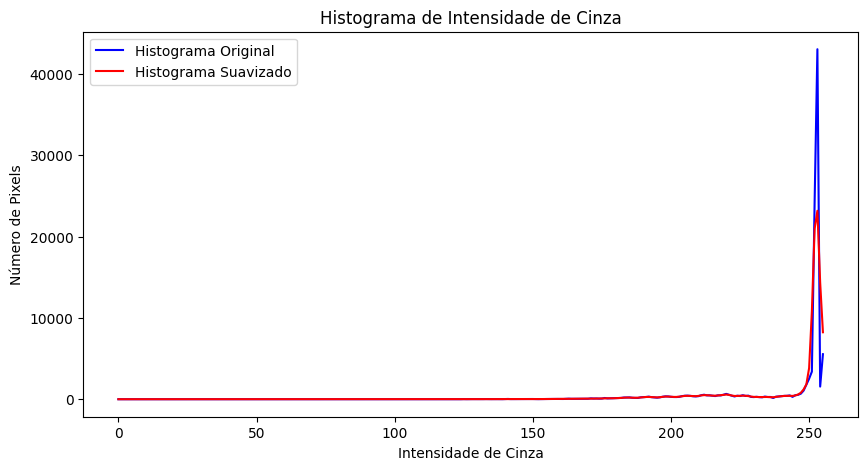

In [13]:
ideal, hist, hist_smooth = verified_otsu(image)
# Plotar histograma
plt.figure(figsize=(10, 5))
plt.plot(hist, label='Histograma Original', color='blue')
plt.plot(hist_smooth, label='Histograma Suavizado', color='red')
plt.title('Histograma de Intensidade de Cinza')
plt.xlabel('Intensidade de Cinza')
plt.ylabel('Número de Pixels')
plt.legend()
plt.show()